In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

T=4 ##num_steps
INF=10000
NOISE=100
ci=0.05/3
lambdas=np.array([1,5,10])
I=len(lambdas)
n_values=np.linspace(5000,INF,T,dtype=np.int)
Ni_values=(ci)*n_values


## Séparation exacte du spectre
- Setting $N_i=100, n=5000$, i.e. $c=0.06$, we can better observe the separation of the spectrum in two continuous bulks  
We can verify the exact separation and the "no eigenvalue outside de support" theorem sing Gaussian and Uniform distributions



100 5000


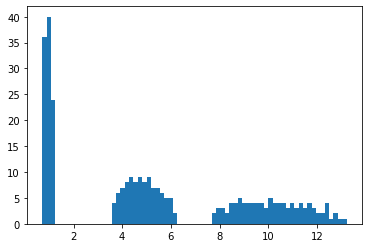

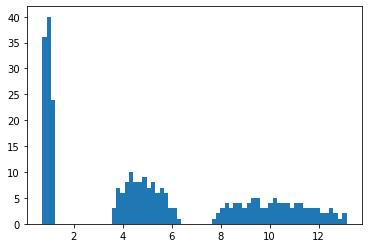

In [206]:
Ni,n=100,5000
#for Ni,n in zip(Ni_values,n_values):
Ni=max(int(Ni),1)
N=Ni*I
print(Ni,n)
l=lambdas[None,:].repeat(Ni,1).reshape(-1)
R3=np.diag(l)

##gaussian (finite curtosis) distribution

def random_spectrum(X,R=R3):
    Sigma=1/n*X.T.conjugate()@R@X


    w=np.linalg.eigvalsh(Sigma,)
    whist=w[w>1e-6]
    plt.hist(whist,bins=int(np.sqrt(n)))
    plt.show()
    return w
X=(np.random.rand(N,n)+1j*np.random.rand(N,n)-0.5-0.5j)*np.sqrt(6)
wunif=random_spectrum(X)
X=(np.random.randn(N,n)+1j*np.random.randn(N,n))/np.sqrt(2)
wgauss=random_spectrum(X)
#np.random.rand(N,n)

- A t-student with $\nu=3$ degrees of freedom does not have a finite 4th moment so the exact separation of the support doesn't occur

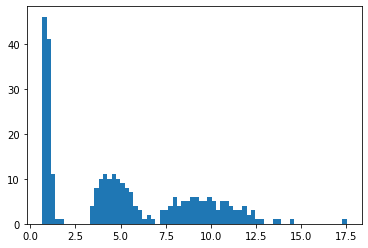

In [99]:
from scipy.stats.distributions import t as tstudent
X=tstudent.rvs(3,size=(N,n), scale=1/np.sqrt(6))+1j*tstudent.rvs(3,size=(N,n), scale=1/np.sqrt(6))
wt=random_spectrum(X)

## Graphe de $x(\tilde{t})$

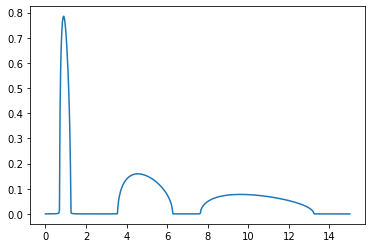

In [24]:
def t_ker(t,u,z,c=0.06):
    """Kernel for fix point algorithm
    Arguments:
    t: current estimate
    u: specter of L^R_\inf
    z: complex argument
    """
    res=1/(-z*(1+u*c*t)+(1-c)*u)
    return res.mean()

def  fix_point(xs,u,
              img_eps=1e-3,cvg_eps=1e-6):
    fs=np.zeros_like(xs)
    t=0
    for i,x in enumerate(xs):
        z=x+1j*img_eps
        err=10*cvg_eps
        
        ##fp iteration
        
        while err>cvg_eps:
            tnew=t_ker(t,u,z)
            err=abs(tnew-t)
            t=tnew
        fs[i]=1/np.pi*t.imag
    
    return fs

L_R=np.array([1,5,10])
xs=np.linspace(0,15,500)
fs=fix_point(xs,L_R)
plt.plot(xs,fs)
        
            
    


    

- Changing paramaters $c$ and $c_i$ can change the overall size of the bulk and relative size of each connected component, respectively

<ipython-input-85-9430062c4ee8>:28: RuntimeWarning: divide by zero encountered in true_divide
  return -1/t+c*((p*u)[None,:]/(t[:,None]*u[None,:]+1)).sum(axis=1)


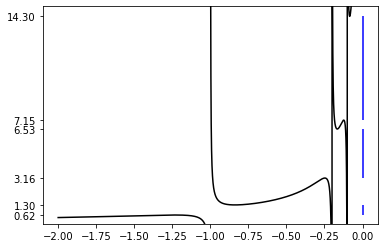

[(0.6157249768843781, 1.2977485656725203),
 (3.158698643651593, 6.529843811090124),
 (7.153408235124997, 14.304912723274942)]

In [85]:
##tracing x(t)

def _which(bulks,x):
    for i,b in enumerate(bulks):
        if b[0]<=x<=b[-1]:
            return i
    return -1
def _bulks(w,eps=0.5):
    w=np.sort(w)
    bs=[[w[0]]]
    bulk=bs[0]
    for t in w[1:]:
        if t-bulk[-1]<eps:
            bulk.append(t)
        else:
            bs.append([t])
            bulk=bs[-1]
    

    

    
    return bs


def x_t(t,u,c=0.15,p=None):
    if p is None: p=np.ones(len(u))/len(u)
    return -1/t+c*((p*u)[None,:]/(t[:,None]*u[None,:]+1)).sum(axis=1)

def spectrum_bulks(spectrum,c=0.06,p=None,plot=False):
    t=np.linspace(-2,-0.0,5000,endpoint=False)
    xs=x_t(t,spectrum,c,p)
    if plot:
        plt.ylim([0,15])
        plt.plot(t,xs,c='k')



    #plt.vlines(0,0,15,color='b')
    cresc_x=np.array([xs[i] for i in range(len(xs)-1) if xs[i+1]>xs[i] and 20>xs[i]>0])
    aux=_bulks(cresc_x)
    #print(aux[0])
    desc_x=np.array([x for x in np.linspace(aux[0][0],aux[-1][-1],2000) if which(aux,x)==-1])
    for eps in np.logspace(0,-1,20):
        bulks=_bulks(desc_x,eps)
        #print(len(bulks))
        if 3<=len(bulks)<=4: 
            break
    bulks=[(b[0],b[-1]) for b in bulks]
    if plot:


        #plt.scatter(np.zeros(len(desc_x)),desc_x,s=0.1)
        plt.vlines(np.zeros(len(bulks)),[b[0] for b in bulks],[b[1] for b in bulks],color='b')
        #cx=cresc_x[np.logical_and(cresc_x>0,cresc_x<15)]
        plt.yticks(np.array(bulks).reshape(-1))
        #plt.scatter(np.zeros(len(cx)),cx,c='r',alpha=1.0,s=5)
        plt.show()
    return bulks



#spectrum_bulks(L_R,plot=True,c=0.1)
#spectrum_bulks(wgauss[wgauss>1e-6],plot=True,c=0.1)

#plt.vlines()

In [324]:
def get_estimates(spectrum,verbose=False,squared_factor=False):
    spectrum=spectrum[spectrum>1e-5]
    sp_bulks=_bulks(spectrum)
    bulks=np.array([(b[0],b[-1]) for b in sp_bulks])
    L=np.diag(spectrum)-np.sqrt(spectrum[:,None]*spectrum[None,:])
    gzeros,_=np.linalg.eigh(L)
    #print(gzeros[gzeros>1e-6])
    idxs=np.digitize(gzeros,bulks.reshape(-1),)
        #plt.scatter(idxs[1:],gzeros[1:])
    
    #idxs[idxs==2]=1  zeros near the bulk
    #idxs[idxs==4]=3
    
    zeros_bulk=[]
    for bin_idx in range(1,2*len(bulks)+2,2):
        zeros_bulk.append(gzeros[idxs==bin_idx])
        
    est=np.zeros(len(sp_bulks))
    for i,(a,b) in enumerate(zip(sp_bulks,zeros_bulk)):
        factor=(len(b)/len(a))
        if squared_factor: factor*=(len(b)/len(a))
        est[i]=(-sum(b)+sum(a))*factor
        
        if verbose: print('Estimative for bulk %d is %.3f' %(i+1,est[i]))
    return est
est=get_estimates(wgauss,True)

Estimative for bulk 1 is 1.009
Estimative for bulk 2 is 5.053
Estimative for bulk 3 is 10.113


In [253]:
## 2b
from tqdm import tqdm
IT=50
ests=[]
for _ in tqdm(range(IT)):
    X=(np.random.randn(N,n)+1j*np.random.randn(N,n))/np.sqrt(2)
    Sigma=1/n*X.T.conjugate()@R@X
    w=np.linalg.eigvalsh(Sigma,)
    ests.append(get_estimates(w))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [10:36<00:00, 12.72s/it]


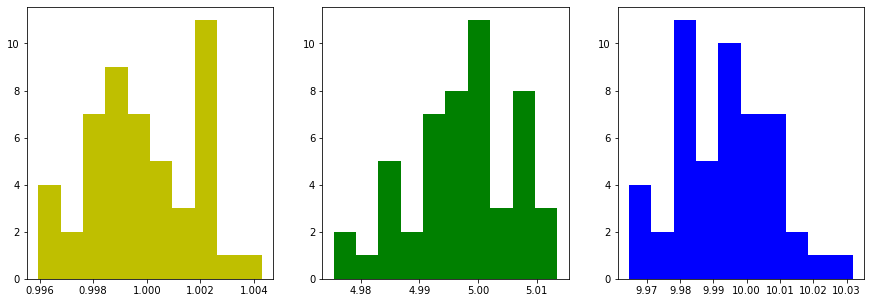

In [285]:
ests=np.array(ests)
fig,axs=plt.subplots(1,3,figsize=(15,5))
for t,c,ax in zip(ests.T,['y','g','b'],axs):
    #plt.subplot(1,3,i+1)
    ax.hist(t*0.99,color=c)
plt.show()

- Above we have the histograms of the estimators multiplied by a factor of 0.99, which is equal to the  factor :
$$\frac{N_\mu^i}{N_\lambda^i}$$
- We believe
- We have gaussian like distribution and a positive bias roughly proportional to $\lambda_i$, ie :
$$
\hat{\lambda_i}\sim \mathcal{N}(1.01\lambda_i,\sigma)
$$

In [326]:
ci=50
T,IT=10,10
I=len(lambdas)
ests=np.zeros((T,IT,I))
naive_ests=np.zeros((T,IT,I))
for t,Ni in tqdm(enumerate(np.linspace(50,120,T))):
    Ni=int(Ni)
    n=ci*Ni
    N=Ni*I
    l=lambdas[None,:].repeat(Ni,1).reshape(-1)
    R=np.diag(l)
    for it in range(IT):
        X=(np.random.randn(N,n)+1j*np.random.randn(N,n))/np.sqrt(2)
        Sigma=1/n*X.T.conjugate()@R@X
        w=np.linalg.eigvalsh(Sigma,)
        bulks=_bulks(w[w>1e-6])
        assert len(bulks)==I
        ests[t,it]=get_estimates(w)
        
        ##naive estimate
        
        for j,b in enumerate(bulks):
            naive_ests[t,it,j]=sum(b)/len(b)
        

10it [16:08, 96.86s/it] 


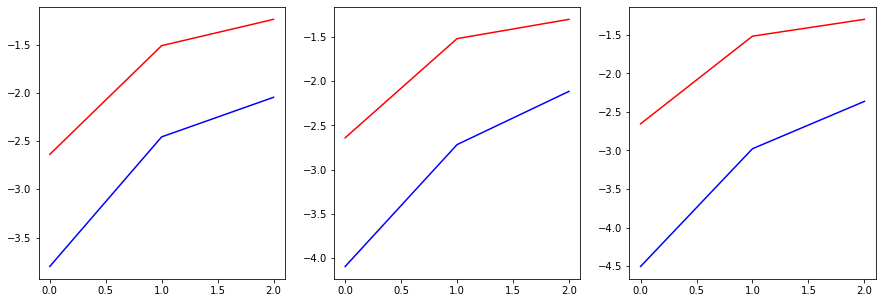

In [302]:
a=ests.mean(axis=1)*0.99-lambdas[None,:]
var_a=ests.std(axis=1)**2
b=naive_ests.mean(axis=1)-lambdas[None,:]
var_b=ests.std(axis=1)**2
fig,axs=plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axs):
    pa=np.log10(a[i]**2+var_a[i])
    pb=np.log10(b[i]**2+var_b[i])
    ax.plot(pa,c='b')
    ax.plot(pb,c='r')

- Above, the log MSE for $n_i$ between 50 and 120. In blue our estimator, in red the naive estimator, which is simply the mean of each bulk

- The estimator's positive bias seems to increase increases with $n$